# Viscous streaming flow for a single oscillating cylinder

In [1]:
using ViscousStreaming

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/ViscousStreaming/UPKy8.ji for ViscousStreaming [47fb7046-13b0-40db-b6a6-74fa44cf0959]
└ @ Base loading.jl:1240


In [2]:
using ProgressMeter
using JLD
import JLD: save, load
using Statistics
import Statistics: mean

In [3]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


### Solve for small-amplitude oscillation of a cylindrical body

The motion of the body is described by oscillatory small-amplitude translation,

$$V_b(\xi,t) = \epsilon \hat{U}(t)$$

where $\epsilon \ll 1$, $\hat{U}(t)$ is a periodic velocity with unit amplitude, and $\xi \in S_b$ (i.e. it lies on the body surface). The associated position of any point on the surface of the body is then described by

$$X_b(\xi,t) = \xi + \epsilon \int_0^t \hat{U}(\tau)d\tau.$$

We will write the flow field in asympotic form, e.g. $v = \epsilon v_1 + \epsilon^2 v_2$, and seek to solve two asymptotic levels of equation (for vorticity)

$$\dfrac{\partial w_1}{\partial t} - \dfrac{1}{Re} \nabla^2 w_1 = 0$$

subject to boundary condition $v_1(\xi,t) = \hat{U}(t)$ for all $\xi \in S_b$. Note that the boundary condition is applied at the initial location of the surface, not its time-varying location.

And at second order,

$$\dfrac{\partial w_2}{\partial t} - \dfrac{1}{Re} \nabla^2 w_2 = -\nabla\cdot(v_1 w_1),$$

subject to boundary condition $v_2(\xi,t) = -\int_0^t \hat{U}(\tau)d\tau \cdot \nabla v_1(\xi,t)$ for all $\xi \in S_b$. This is also applied at the initial location of the surface.

Thus, to solve this problem, we will set up a state vector that contains $w_1$, $w_2$, and an unscaled 'body' state $x_c$, $y_c$. These latter components will be used to hold the components of $\Delta\hat{X} \equiv \int_0^t \hat{U}(\tau)d\tau$.

A fluid particle, initially at a location $x$, is subjected to a slightly different velocity, $U(x,t)$, over the ensuing oscillation period, since it is advected by the local velocity to sample nearby points. Its first-order velocity is simply $U_1(x,t) = v_1(x,t)$. Its second order velocity, however, is

$$U_2(x,t) = v_2(x,t) + \int_0^t v_1(x,\tau)d\tau \cdot \nabla v_1(x,t)$$

In particular, if the particle is initially on the surface, $x \in S_b$, then $v_1 = \hat{U}$, and the second term of this expression above cancels $v_2$, so that $U_2 = 0$. This ensures that the particle continues to oscillate with the body's surface velocity. Let us define an Eulerian displacement field,

$$\Delta X(x,t) = \int_0^t v(x,\tau)d\tau, \quad \Delta X(x,0) = 0,$$

or, equivalently,

$$\dfrac{d\Delta X}{dt} = v(x,t), \quad \Delta X(x,0) = 0.$$

Then, expanding $\Delta X$ in an asymptotic sequence, $\Delta X = \epsilon \Delta X_1 + \epsilon^2 \Delta X_2$, we have

$$U_2(x,t) = v_2(x,t) + \Delta X_1(x,t) \cdot \nabla v_1(x,t)$$

### Set the oscillation parameters

In [4]:
Re = 40.0
ϵ = 0.1

0.1

### Generate the analytical solution

In [55]:
p = StreamingParams(ϵ,Re)

Streaming flow parameters with Re = 40.0, ϵ = 0.1


In [56]:
s = AnalyticalStreaming(p)

Maximum residual on W₁ = 1.1368683772161603e-13
BC residual on Ψ₁(1) = 2.7755575615628914e-17
BC residual on dΨ₁(1) = 5.23691153334427e-16
Maximum residual on Ws₂ = 1.3073986337985843e-12
BC residual on Ψs₂(1) = 0.0
BC residual on dΨs₂(1) = 8.881784197001252e-16
Maximum residual on W₂ = 2.1179418493558537e-12
BC residual on Ψ₂(1) = 1.734723475976807e-17
BC residual on dΨ₂(1) = 0.0


Analytical streaming flow solution for
single cylinder with Re = 40.0, ϵ = 0.1


### Set the motion for Navier-Stokes solution

In [5]:
Ω = 1.0  # angular frequency
Ax = 1.0 # x amplitude (before scaling by ϵ)
ϕx = 0.0 # phase lead of x motion
Ay = 0.0 # y amplitude
ϕy = 0.0 # phase lead of y motion
oscil = RigidBodyMotions.RigidBodyMotion(RigidBodyMotions.Oscillation(Ω,Ax,ϕx,Ay,ϕy))
Tp = 2π/Ω

6.283185307179586

#### Let's plot it just to check
Keep in mind that this is the 'unscaled' form of the motion; the actual motion would be multiplied by $\epsilon$.

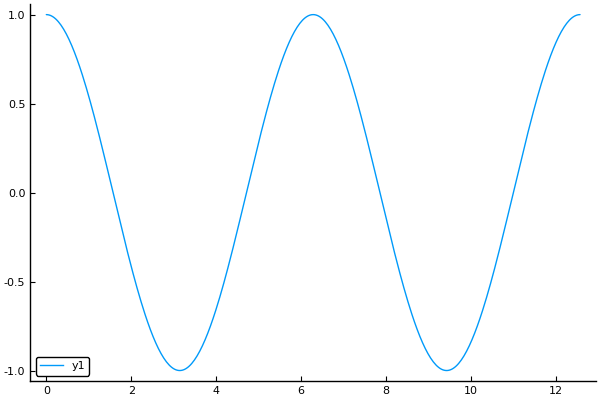

In [6]:
t = range(0.0,stop=4π,length=401)
ux = map(ti -> real(oscil(ti)[2]),t) # u component of velocity of centroid
plot(t,ux)

#### Set up points on the body:

In [20]:
n = 150
body = Bodies.Ellipse(1.0,0.5,n)

Elliptical body with 150 points and semi-axes (1.0,0.5)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Transform the body with a specified initial position and orientation.

In [71]:
cent = (1.0,0.0)
α = 30π/180
T! = RigidTransform(cent,α)
T!(body) # transform the body to the current configuration

Elliptical body with 150 points and semi-axes (1.0,0.5)
   Current position: (1.0,0.0)
   Current angle (rad): 0.5235987755982988


Now set up the coordinate data for operator construction

#### Set up the domain

In [38]:
xlim = (-5.98,5.98)
ylim = (-5.98,5.98)

(-5.98, 5.98)

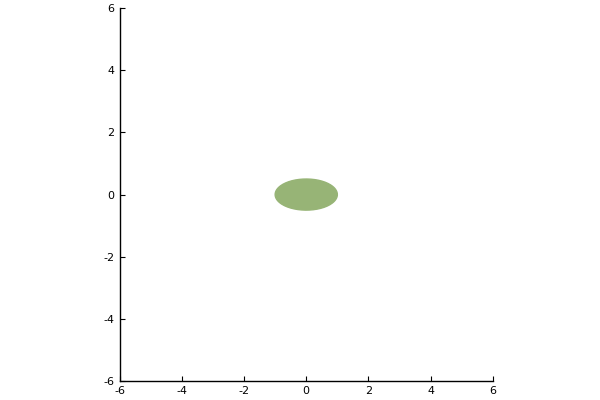

In [27]:
plot(body,xlim=xlim,ylim=ylim)

### Now set up the system

The discretized equations include the constraint forces on the surface, used to enforce the boundary conditions. The first level can be written as

$\dfrac{dw_1}{dt} - \dfrac{1}{Re}Lw_1 + C^T E^T f_1 = 0,\quad -E C L^{-1}w_1 = \hat{U}, \quad w_1(0) = 0$

where $E$ is the interpolation operator, $E^T$ is the regularization operator, $C^T$ is the rot (curl) operator, and $f_1$ represents the vector of discrete surface forces.

The second asymptotic level is written as

$\dfrac{dw_2}{dt} - \dfrac{1}{Re}Lw_2 + C^T E^T f_2 = -N(w_1),\quad -E C L^{-1}w_2 = \Delta\hat{X}\cdot E G C L^{-1}w_1, \quad w_2(0) = 0$

where $N$ represents the non-linear convective term. We must also advance the state $\Delta\hat{X}$:

$\dfrac{d\Delta\hat{X}}{dt} = \hat{U}, \quad \Delta\hat{X}(0) = 0$

To account for the fluid particle motion, we will also integrate the Eulerian displacement field $\Delta X_1$:

$\dfrac{d\Delta X_1}{dt} = v_1, \quad \Delta X_1(x,0) = 0$


#### Set the cell size and time step size

In [31]:
Δx = 0.02
Co = 0.5
Fo = 0.5
Δt = min(π*Co*Δx,π*Fo*Δx^2*Re)

0.025132741228718343

#### Get the solver and system

In [72]:
@time solver, sys = ViscousStreaming.initialize_solver(Re,Δx,xlim,ylim,Δt,body,oscil)

 67.832437 seconds (551.29 M allocations: 33.847 GiB, 8.26% gc time)


(Order-3 IF-HERK integrator with
   State of type Tuple{Nodes{Dual,600,600},Nodes{Dual,600,600},Edges{Primal,600,600},Array{Float64,1}}
   Force of type Tuple{VectorData{150},VectorData{150},Array{Float64,1},Array{Float64,1}}
   Time step size 0.025132741228718343
, Navier-Stokes system on a grid of size 600 x 600)

### Advance the system

Set the final time to integrate to

In [73]:
tf = 5Δt # 25*Tp+Δt

0.1256637061435917

Set up a restart writing plan

In [74]:
restart_Δt = 10Δt # rate at which restarts are written
filen = "restart_eps"*string(ϵ)*"_dx_"*string(Δx)*"_dt_"*string(Δt)*".jld"
R = WritePlan(filen,restart_Δt,["u","t"])

WritePlan("restart_eps0.1_dx_0.02_dt_0.025132741228718343.jld", 0.2513274122871834, ["u", "t"])

Initialize the state vector and the history vectors

In [75]:
# change initflag to false if you want to load from a restart file
initflag = true
if initflag
    t = 0.0
    u = ViscousStreaming.initialize_state(sys)
else
    load(R,"u")
    load(R,"t")
end
T = t+Δt:Δt:tf

nothing

#### Set up a storage structure to save history data while solution proceeds

In [76]:
# Initial time to start storing data
tmin_store = 0.0  #24Tp

# Final time to start storing data
tmax_store = 4Δt  #tmin_store + Tp - Δt

# Rate at which to store field data
tsample = Δt

# Rate at which to store field data
S = StorePlan(tmin_store,tmax_store,tsample,u,t,htype=PeriodicHistory)
data_history = initialize_storage(S)
nothing

In [77]:
@time @showprogress for ti in t+Δt:Δt:tf
    global t, u, f = solver(t,u)
    
    store_data!(data_history,t,S,deepcopy(u),t)
    save(t,R,deepcopy(u),t)

end
println("solution completed through time t = ",t)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


  6.188280 seconds (8.46 k allocations: 2.051 GiB, 17.41% gc time)
solution completed through time t = 0.1256637061435917


#### Compute the velocity field data associated with the stored solution interval

In [52]:
u₀ = Edges(Primal, u[1])
ux = History(u₀.u,htype=PeriodicHistory)
uy = History(u₀.v,htype=PeriodicHistory)
u1x = History(u₀.u,htype=PeriodicHistory)
u1y = History(u₀.v,htype=PeriodicHistory)
utemp1 = zero(u₀)
@showprogress for i in eachindex(data_history[1])
    utemp1 .=  -ϵ*curl(sys.L\data_history[1][i]) 
    push!(u1x,deepcopy(utemp1.u))
    push!(u1y,deepcopy(utemp1.v))
    utemp1 .+=  -ϵ^2*curl(sys.L\data_history[2][i])
    push!(ux,deepcopy(utemp1.u))
    push!(uy,deepcopy(utemp1.v))
end
vel_history = [ux,uy,u1x,u1y];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


#### Store the data for later use

In [54]:
g = sys.grid
savefile = "./CFD_data/1cylinder_steady_history_eps"*string(ϵ)*"_dx_"*string(Δx)*"_dt_"*string(Δt)*".jld"

"./CFD_data/1cylinder_steady_history_eps0.1_dx_0.02_dt_0.025132741228718343.jld"

In [53]:
JLD.@save savefile data_history vel_history g Δt 

#### Plotting first order solution

In [78]:
# shorthand name
data = data_history;

In [79]:
iplot = length(data[1]) # index of time step for plotting
ω₁ = vorticity(data[1][iplot],sys)
q₁ = velocity(data[1][iplot],sys)
ψ₁ = streamfunction(data[1][iplot],sys)
nothing

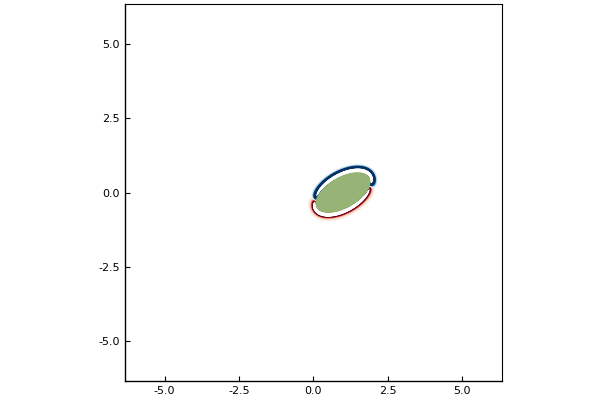

In [80]:
xg,yg = coordinates(u[1],sys.grid)
plot(xg,yg,ω₁,levels=range(-2,2,length=30),clim=(-1,1),color=:RdBu)
plot!(body)

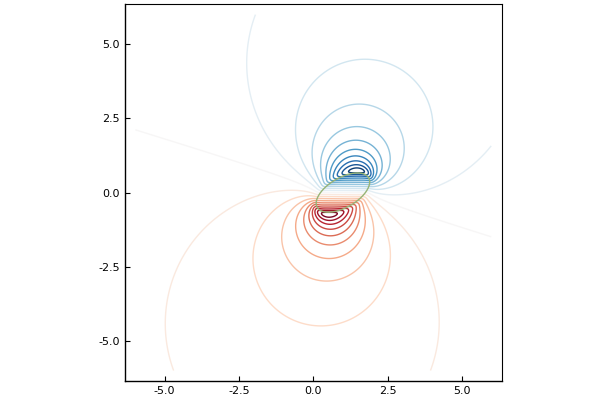

In [81]:
plot(xg,yg,ψ₁,levels=range(-1,1,length=31),color=:RdBu)
plot!(body,fill=:false)

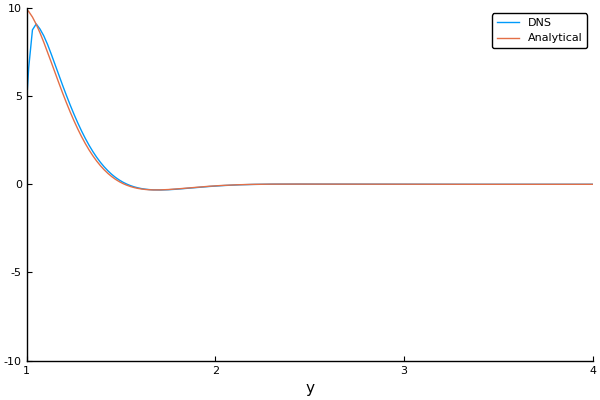

In [57]:
ix = 301
plot(yg,ω₁[ix,:],ylim=(-10,10),xlim=(1,4),label="DNS",xlabel="y")
plot!(yg,map(y -> vorticity(xg[ix],y,data[5][iplot],firstorder(s)),abs.(yg)),label="Analytical")
#plot!(yg,-real(W₁.(abs.(yg))*exp(-im*thist[iplot])))

#### History of DNS results at an observation point
Not yet using interpolation, so we specify the indices of the observation point rather than x,y coordinates

The following functions pick off the vorticity and velocity histories at an index pair. Note that u and v components that share the same indices are at different physical locations, and each are at different locations from vorticity.

In [58]:
function vorticity_history(sample_index::Tuple{Int,Int},whist,sys)
    i, j = sample_index
    return map(x -> vorticity(x,sys)[i,j],whist)
end
function velocity_history(sample_index::Tuple{Int,Int},whist,sys)
    i, j = sample_index
    tmp = reshape(collect(Iterators.flatten(
                map(x -> (q = velocity(x,sys); [q.u[i,j], q.v[i,j]]),whist))),
                2,length(whist))
    return tmp[1,:], tmp[2,:]
end
# This computes the history of the rhs of the second-order equation at the sample point
function nl_history(sample_index::Tuple{Int,Int},whist,sys)
    i, j = sample_index
    return map(w1 -> TimeMarching.r₁(w1,0.0,sys)[i,j]/cellsize(sys),whist)
end
function centroid_history(Xhist)
    tmp = reshape(collect(Iterators.flatten(Xhist)),2,length(Xhist))
    return tmp[1,:], tmp[2,:]
end

centroid_history (generic function with 1 method)

In [113]:
sampij = (301,360) # indices of sample point

(301, 360)

In [114]:
ω₁hist = vorticity_history(sampij,data[1],sys);

Get coordinates of sample point on dual node grid

In [115]:
xg, yg = coordinates(u[1],sys.grid)
xeval = xg[sampij[1]]
yeval = yg[sampij[2]]
reval = sqrt(xeval^2+yeval^2)
coseval = xeval/reval
sineval = yeval/reval
reval

1.1900420160649792

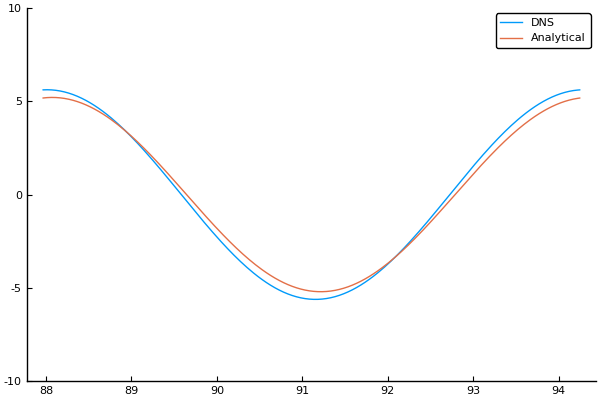

In [116]:
plot(data[5],ω₁hist,label="DNS",ylim=(-10,10))
plot!(data[5],vorticity(xeval,yeval,data[5],firstorder(s)),label="Analytical") # note that we correct the sign of W₁ here
#plot!(thist,real.(-W₁(reval)*sineval*exp.(-im*thist)),label="Analytical") # note that we correct the sign of W₁ here

In [118]:
u₁hist, v₁hist = velocity_history(sampij,data[1],sys);

Get the coordinates of the sample point in the u-component edges for plotting this component

In [122]:
xuedge, yuedge, xvedge, yvedge = coordinates(Edges(Primal,u[1]),sys.grid)
xeval = xuedge[sampij[1]]
yeval = yuedge[sampij[2]]
reval = sqrt(xeval^2+yeval^2)
coseval = xeval/reval
sineval = yeval/reval
reval

1.2000416659433122

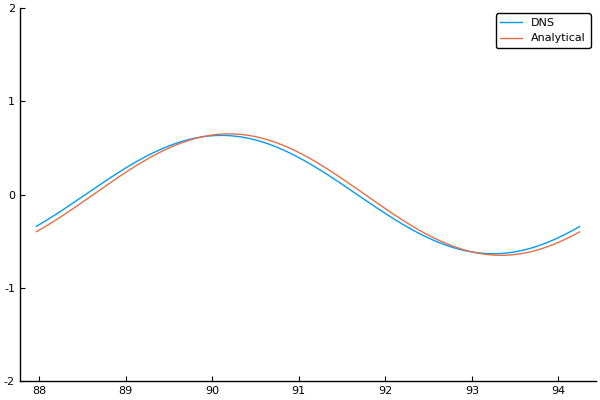

In [123]:
plot(data[5],u₁hist,ylim=(-2,2),label="DNS")
plot!(data[5],uvelocity(xeval,yeval,data[5],firstorder(s)),label="Analytical")

Plot the centroid history

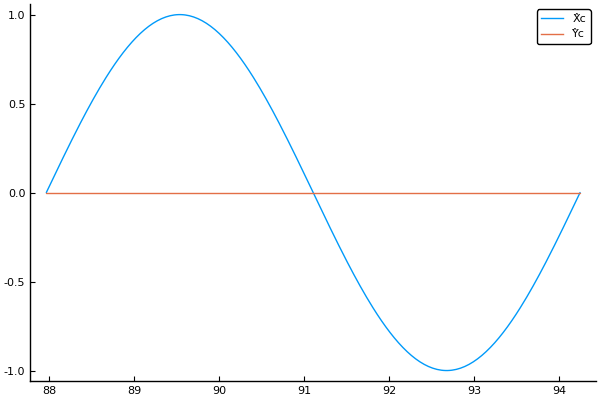

In [66]:
xhist, yhist = centroid_history(data[4])
plot(data[5],xhist,label="X̂c")
plot!(data[5],yhist,label="Ŷc")

#### The second-order equation

In [82]:
iplot = length(data[2])
ω₂ = vorticity(data[2][iplot],sys)
q₂ = velocity(data[2][iplot],sys)
ψ₂ = streamfunction(data[2][iplot],sys)
nothing

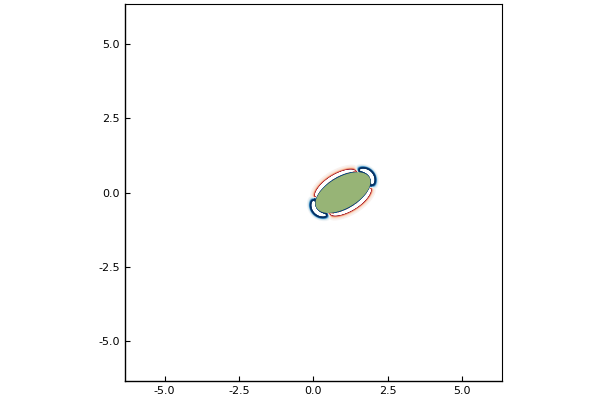

In [83]:
xg,yg = coordinates(u[2],sys.grid)
plot(xg,yg,ω₂,levels=range(-1,1,length=30),color=:RdBu,clim=(-1,1))
plot!(body)

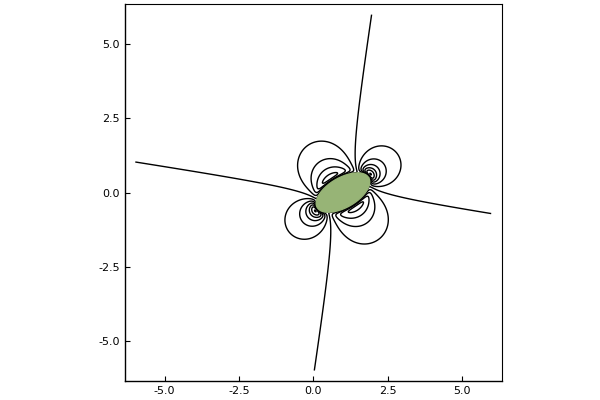

In [84]:
xg,yg = coordinates(u[2],sys.grid)
plot(xg,yg,ψ₂,levels=range(-0.2,0.2,length=31),color=:black,clim=(-0.1,0.1))
plot!(body)

Compute the mean vorticity field over a period, $\overline{w}_2$

In [73]:
iplot = length(data[2])
itr = iplot-floor(Int,2π/(Ω*Δt))+1:iplot
w2avg = mean(data[2][itr])
ω̄₂ = vorticity(w2avg,sys)
ψ̄₂ = streamfunction(w2avg,sys);

In [45]:
ψ̄₂exfield = Nodes(Fields.Dual,u[1])
ψ̄₂exfield .= [streamfunction(x,y,secondordermean(s)) for x in xg, y in yg];

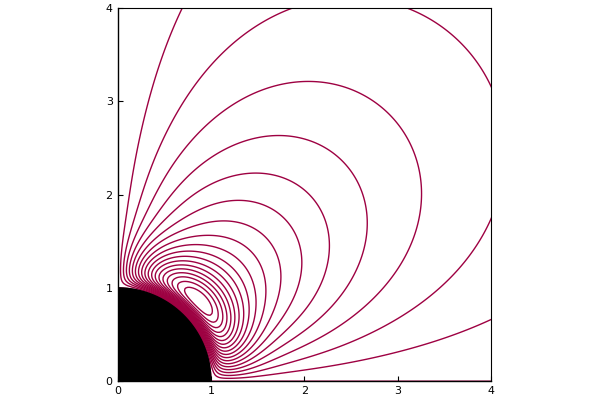

In [74]:
plot(xg,yg,ψ̄₂,levels=range(-0.2,0.1,length=31),clim=(1,2),xlim=(0,4),ylim=(0,4))
#plot!(xg,yg,ψ̄₂exfield,levels=range(-0.2,0.1,length=31),clim=(1,2),xlim=(0,4),ylim=(0,4))
plot!(body,fillcolor=:black,linecolor=:black)

In [971]:
sqrt(xg[119]^2+yg[119]^2)

0.9899494936611667

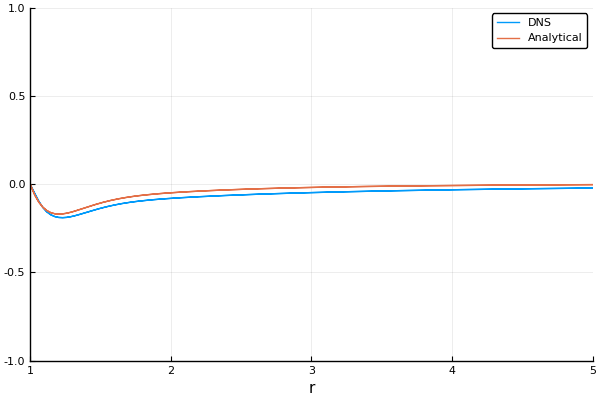

In [75]:
ig = 120
plot(sqrt.(xg[ig:end].^2+yg[ig:end].^2),map(i -> ψ̄₂[i,i],ig:length(xg)),ylim=(-1,1),xlim=(1,5),label="DNS",xlabel="r")
plot!(sqrt.(xg[ig:end].^2+yg[ig:end].^2),map((x,y) -> streamfunction(x,y,secondordermean(s)),xg[ig:end],yg[ig:end]),label="Analytical",grid=:true)

In [76]:
sampij = (350,350) # indices of sample point

(350, 350)

In [78]:
xg, yg = coordinates(u[1],sys.grid)
xeval = xg[sampij[1]]
yeval = yg[sampij[2]]
reval = sqrt(xeval^2+yeval^2)

1.4000714267493641

In [79]:
ω₂hist = vorticity_history(sampij,data[2],sys);

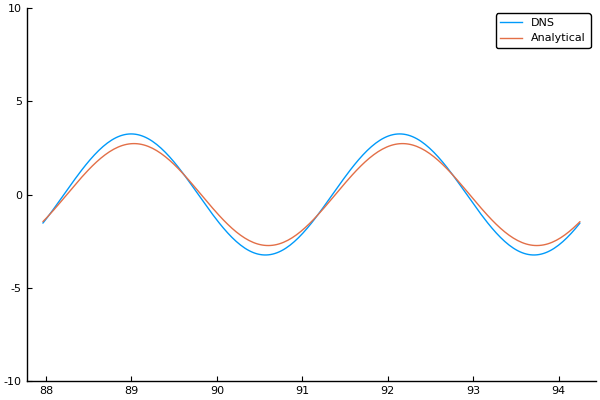

In [83]:
plot(data[5],ω₂hist .- mean(ω₂hist),label="DNS",ylim=(-10,10))
plot!(data[5],vorticity(xeval,yeval,data[5],secondorder(s)),label="Analytical")

In [84]:
xuedge, yuedge, xvedge, yvedge = coordinates(Edges(Primal,u[1]),sys.grid)
xeval = xuedge[sampij[1]]
yeval = yuedge[sampij[2]]
reval = sqrt(xeval^2+yeval^2)

1.4071602609511114

In [85]:
u₂hist, v₂hist = velocity_history(sampij,data[2],sys);

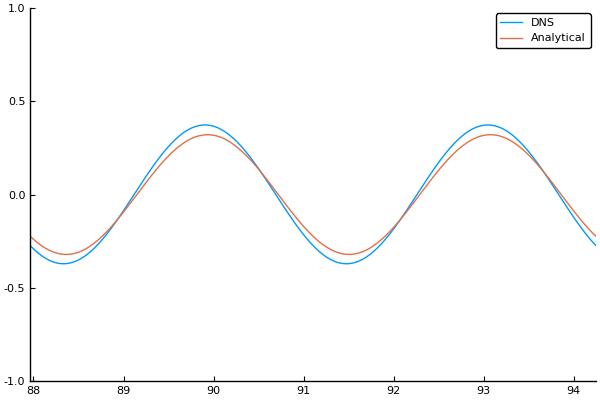

In [88]:
plot(data[5],u₂hist .- mean(u₂hist),ylim=(-1,1),label="DNS")
plot!(data[5],uvelocity(xeval,yeval,data[5],secondorder(s)),xlim=(2*14π,2*15π),label="Analytical")

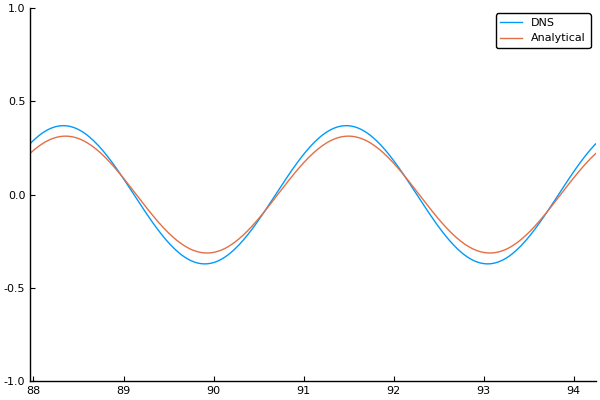

In [92]:
plot(data[5],v₂hist .- mean(v₂hist),ylim=(-1,1),label="DNS")
plot!(data[5],vvelocity(xeval,yeval,data[5],secondorder(s)),xlim=(2*14π,2*15π),label="Analytical")

In [177]:
iplot = 230
println("Time/period = ",thist[iplot]/(2π))
usamp = (w1hist[iplot],w2hist[iplot],dX1hist[iplot],dX2hist[iplot],X̂hist[iplot])
rhs1samp = TimeMarching.r₁(usamp,thist[iplot])
rhs2samp = TimeMarching.r₂(usamp,thist[iplot]);

Time/period = 29.920000000003718


#### The right-hand side of the second-order constraint equation

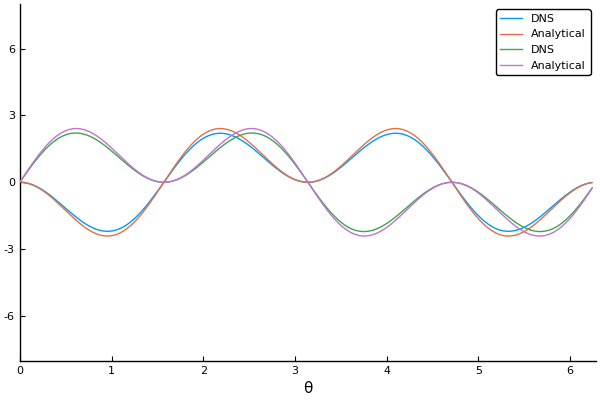

In [178]:
θ = range(0,2π,length=length(coords.u)+1)
plot(θ[1:end-1],rhs2samp[2].u,xlim=(0,2π),ylim=(-8,8),label="DNS",xlabel="θ")
plot!(θ[1:end-1],map((x,y) -> u₂ex(x,y,thist[iplot]),cos.(θ[1:end-1]),sin.(θ[1:end-1])),label="Analytical")
plot!(θ[1:end-1],rhs2samp[2].v,xlim=(0,2π),ylim=(-8,8),label="DNS",xlabel="θ")
plot!(θ[1:end-1],map((x,y) -> v₂ex(x,y,thist[iplot]),cos.(θ[1:end-1]),sin.(θ[1:end-1])),label="Analytical")

#### History of RHS of second-order equation at sample point

In [180]:
sampij = (340,340) # indices of sample point

(340, 340)

In [181]:
xg, yg = coordinates(w₀,sys.grid)
xeval = xg[sampij[1]]
yeval = yg[sampij[2]]
reval = sqrt(xeval^2+yeval^2)
coseval = xeval/reval
sineval = yeval/reval
sin2eval = 2*sineval*coseval
reval

1.1172287142747452

In [182]:
rhshist = nl_history(sampij,w1hist,sys);

In [183]:
itr = length(thist)-floor(Int,2π/(Ω*Δt))+1:length(thist)
println("Mean value of DNS-computed RHS = ",Statistics.mean(rhshist[itr]))
println("Mean value analytical RHS = ",real(f₀(reval)/p.Re*sin2eval))

Mean value of DNS-computed RHS = 6.286507921693011
Mean value analytical RHS = 6.355401031954797


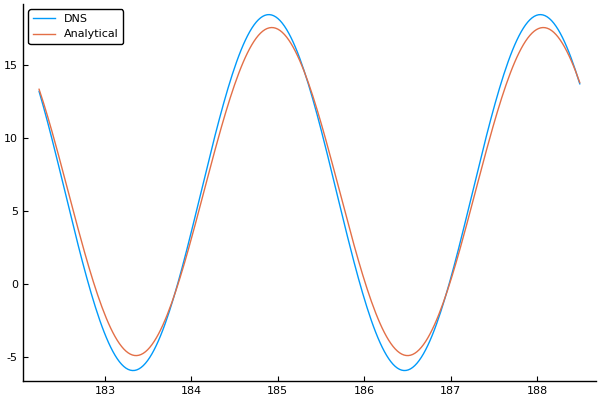

In [184]:
plot(thist,rhshist,label="DNS")
plot!(thist,real.(f₀(reval)/p.Re .+ g₀(reval)/p.Re*exp.(-2im*thist))*sin2eval,label="Analytical")

#### Compute the drift streamfunction

$\psi_d = \frac{1}{2} \overline{v_1 \times \Delta X_1}$

In [95]:
itr = length(data[5])-floor(Int,2π/(Ω*Δt))+1:length(data[5])
vx = zero(u[1]) 
vy = zero(u[1]) 
Xx = zero(u[1]) 
Xy = zero(u[1])
ψd = zero(u[1])
ψdhist = []
for (i,dX) in enumerate(data[3])
    ViscousFlow.Fields.interpolate!((vx,vy),curl(sys.L\data[1][i])) # -v₁, on the dual nodes
    ViscousFlow.Fields.interpolate!((Xx,Xy),dX) # ΔX₁, on the dual nodes
    ψd .= 0.5*(Xx∘vy-Xy∘vx) # 0.5(v₁ × ΔX₁)
    push!(ψdhist,ψd)
end
ψd .= mean(ψdhist[itr]);

#### Plot the streamlines of the mean

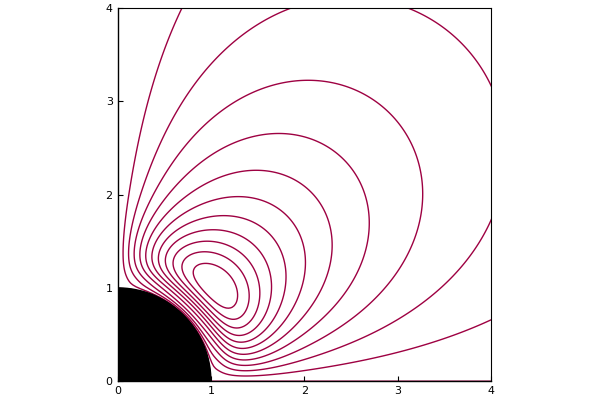

In [96]:
xg,yg = coordinates(u[1],sys.grid)
ψ̄₂d = deepcopy(ψ̄₂)
ψ̄₂d .+= ψd
plot(xg,yg,ψ̄₂d,levels=range(-0.2,0.1,length=31),clim=(1,2),xlim=(0,4),ylim=(0,4))
#plot!(xg,yg,ψ̄₂exfield,levels=range(-0.5,0.5,length=31),clim=(-2,-2),xlim=(0,4),ylim=(0,4))
plot!(body,fillcolor=:black,linecolor=:black)